In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
!{sys.executable} -m pip install PyGithub

     |████████████████████████████████| 208 kB 880 kB/s eta 0:00:01


In [3]:
import numpy as np
import os
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from issue_tagging_bot.issue_data import Stage1PreprocData, Stage2PreprocData

root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H-%M-%S")
    return os.path.join(root_logdir, run_id)

In [3]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006 --bind_all

In [3]:
stage2 = Stage2PreprocData()
train_set, val_set, test_set = stage2.to_datasets()

In [21]:
def only_nixos_labels(dataset: tf.data.Dataset) -> tf.data.Dataset:                                                                                                                     
    return dataset.map(lambda issue_body, labels, issue_num: (issue_body, labels[-1]))                                                                                                                           

In [22]:
train_set = train_set.shuffle(buffer_size=100000, seed=42, reshuffle_each_iteration=True)

train_set_without_issue_num = only_nixos_labels(train_set).batch(300).prefetch(1)
val_set_without_issue_num = only_nixos_labels(val_set).batch(1)
test_set_without_issue_num = only_nixos_labels(test_set).batch(1)

In [177]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[1000,]),
    #tf.keras.layers.Dense(20, activation="relu"),
    #tf.keras.layers.Dropout(0.4),
    #tf.keras.layers.Dense(100, activation="relu"),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    loss="binary_crossentropy",
    optimizer="adam", 
    metrics=[
        tf.keras.metrics.Accuracy(name="acc"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

In [19]:
run_logdir = get_run_logdir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
history = model.fit(
    train_set_without_issue_num,
    epochs=5,
    validation_data=val_set_without_issue_num,
    callbacks=[tensorboard_cb],
)

Train for 42 steps, validate for 1600 steps
Epoch 1/5
42/42 [==============================] - 11s 259ms/step - loss: 8.5795 - accuracy: 0.2664 - false_negatives_2: 867.0000 - false_positives_2: 979.0000 - auc_2: 0.4984 - precision_2: 0.0738 - recall_2: 0.0825 - val_loss: 0.3851 - val_accuracy: 0.0000e+00 - val_false_negatives_2: 121.0000 - val_false_positives_2: 14.0000 - val_auc_2: 0.4736 - val_precision_2: 0.0667 - val_recall_2: 0.0082
Epoch 2/5
42/42 [==============================] - 22s 524ms/step - loss: 1.2434 - accuracy: 6.3684e-04 - false_negatives_2: 861.0000 - false_positives_2: 882.0000 - auc_2: 0.5086 - precision_2: 0.0870 - recall_2: 0.0889 - val_loss: 0.3900 - val_accuracy: 0.0000e+00 - val_false_negatives_2: 122.0000 - val_false_positives_2: 13.0000 - val_auc_2: 0.5024 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/5
42/42 [==============================] - 8s 188ms/step - loss: 0.7152 - accuracy: 0.0000e+00 - false_negatives_2: 899.0000 - false_posit

In [23]:
model.evaluate(test_set_without_issue_num)

1500/1500 [==============================] - 3s 2ms/step - loss: 0.2562 - accuracy: 0.9320


[0.25615801994372783, 0.932]

In [53]:
def evaluate_model(model, dataset=test_set_without_issue_num, threshold=0.5):
    predictions = model.predict(dataset).reshape(-1)
    predictions = np.array(list(map(lambda val: 1 if val >= threshold else 0, predictions)))
    real_vals = np.array(list(dataset.map(lambda x, p: p).as_numpy_iterator())).reshape(-1)
    return confusion_matrix(real_vals, predictions)

In [ ]:
evaluate_model(model, test_set_without_issue_num, threshold=0.1)

# Reweight Categories

In [171]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [138]:
neg_in_train, pos_in_train = np.bincount(list(train_set_without_issue_num.unbatch().map(lambda x, y: y).as_numpy_iterator()))
total_in_train = neg_in_train + pos_in_train
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total_in_train, pos_in_train, 100 * pos_in_train / total_in_train))

Examples:
    Total: 12562
    Positive: 945 (7.52% of total)



In [110]:
weight_for_0 = (1 / neg_in_train)*(total_in_train)/2.0 
weight_for_1 = (1 / pos_in_train)*(total_in_train)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.54
Weight for class 1: 6.65


In [178]:
run_logdir = get_run_logdir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
history = model.fit(
    train_set_without_issue_num,
    epochs=100,
    validation_data=val_set_without_issue_num,
    callbacks=[tensorboard_cb, early_stopping],
    #class_weight = class_weight,
)

Train for 42 steps, validate for 1600 steps
Epoch 1/100
42/42 [==============================] - 11s 262ms/step - loss: 6.4218 - acc: 0.2772 - tn: 10736.0000 - fp: 881.0000 - fn: 865.0000 - tp: 80.0000 - precision: 0.0832 - recall: 0.0847 - auc: 0.5056 - val_loss: 6.4533 - val_acc: 0.1075 - val_tn: 1244.0000 - val_fp: 234.0000 - val_fn: 102.0000 - val_tp: 20.0000 - val_precision: 0.0787 - val_recall: 0.1639 - val_auc: 0.4993
Epoch 2/100
42/42 [==============================] - 28s 668ms/step - loss: 5.4827 - acc: 0.1836 - tn: 10707.0000 - fp: 910.0000 - fn: 875.0000 - tp: 70.0000 - precision: 0.0714 - recall: 0.0741 - auc: 0.4992 - val_loss: 5.2612 - val_acc: 0.2331 - val_tn: 1413.0000 - val_fp: 65.0000 - val_fn: 117.0000 - val_tp: 5.0000 - val_precision: 0.0714 - val_recall: 0.0410 - val_auc: 0.5048
Epoch 3/100
42/42 [==============================] - 8s 188ms/step - loss: 5.1076 - acc: 0.1608 - tn: 10778.0000 - fp: 839.0000 - fn: 869.0000 - tp: 76.0000 - precision: 0.0831 - recall: 0

In [159]:
model.evaluate(val_set_without_issue_num)

1600/1600 [==============================] - 27s 17ms/step - loss: 0.5279 - acc: 0.0000e+00 - tn: 1478.0000 - fp: 0.0000e+00 - fn: 122.0000 - tp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5027 3s - loss: 0.5249 - acc: 0.0000e+00 - tn: 1312.0000 - fp: 0.0000e+00 - fn: 108.0000 - tp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc:


[0.5278628955127757, 0.0, 1478.0, 0.0, 122.0, 0.0, 0.0, 0.0, 0.5026648]

In [113]:
evaluate_model(model, val_set_without_issue_num, threshold=0.9)

array([[893, 585],
       [ 79,  43]])

In [160]:
baseline_results = model.evaluate(test_set_without_issue_num, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)

loss :  0.4839977128568723
acc :  0.0
tn :  1397.0
fp :  1.0
fn :  101.0
tp :  1.0
precision :  0.5
recall :  0.009803922
auc :  0.5585851


In [173]:
train_predictions_baseline = model.predict(train_set_without_issue_num)
test_predictions_baseline = model.predict(test_set_without_issue_num)

In [142]:
test_predictions_baseline

array([[4.10647225e-03],
       [1.81976215e-29],
       [2.74679908e-24],
       ...,
       [1.10910985e-11],
       [3.83597042e-04],
       [6.55808799e-06]], dtype=float32)

In [162]:
def plot_cm(dataset, predictions, threshold=0.5):
    labels = np.array(list(dataset.map(lambda x, p: p).as_numpy_iterator())).reshape(-1)
    cm = confusion_matrix(labels, predictions >= threshold)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Issues that are correctly not labeled "nixos" (True Negatives): ', cm[0][0])
    print('Issues that are INCORRECTLY labeled "nixos" (False Positives): ', cm[0][1])
    print('Issues that should be labeled "nixos", but are INCORRECTLY not labeled (False Negatives): ', cm[1][0])
    print('Issues that are correctly labeled "nixos" (True Positives): ', cm[1][1])
    #print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Issues that are correctly not labeled "nixos" (True Negatives):  1292
Issues that are INCORRECTLY labeled "nixos" (False Positives):  106
Issues that should be labeled "nixos", but are INCORRECTLY not labeled (False Negatives):  93
Issues that are correctly labeled "nixos" (True Positives):  9


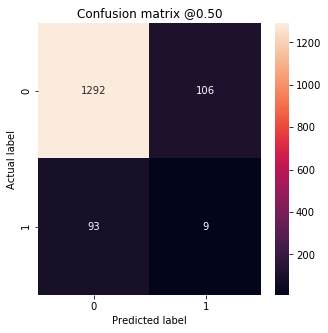

In [174]:
plot_cm(test_set_without_issue_num, test_predictions_baseline, threshold=0.5)

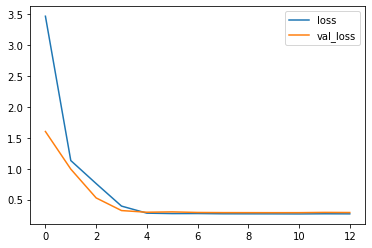

In [164]:
dict_you_want = { your_key: history.history[your_key] for your_key in ["loss", "val_loss"] }
pd.DataFrame(dict_you_want).plot()

In [165]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(
            history.epoch,
            history.history[metric],
            #color=colors[0],
            label='Train'
        )
        plt.plot(
            history.epoch,
            history.history['val_'+metric],
            #color=colors[0],
            linestyle="--",
            label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
#         if metric == 'loss':
#             plt.ylim([0, plt.ylim()[1]])
#         elif metric == 'auc':
#             plt.ylim([0.8,1])
#         else:
#             plt.ylim([0,1])

        plt.legend()


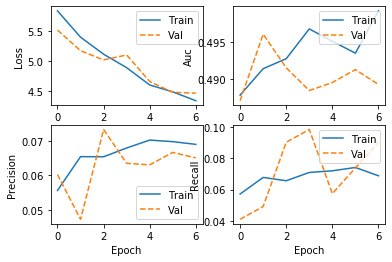

In [175]:
plot_metrics(history)

# RNN

In [185]:
stage2 = Stage2PreprocData()
train_set, val_set, test_set = stage2.to_datasets()
train_set = train_set.shuffle(buffer_size=100000, seed=42, reshuffle_each_iteration=True)

def only_nixos_labels(dataset: tf.data.Dataset) -> tf.data.Dataset:                                                                                                                     
    return dataset.map(lambda issue_body, labels, issue_num: (issue_body, labels[-1]))   

In [205]:
train_set_without_issue_num = only_nixos_labels(train_set).batch(300).prefetch(1)
val_set_without_issue_num = only_nixos_labels(val_set).batch(1)
test_set_without_issue_num = only_nixos_labels(test_set).batch(1)

In [206]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape([1000, 1], input_shape=[1000]),
    tf.keras.layers.SimpleRNN(20, return_sequences=True),
    tf.keras.layers.SimpleRNN(20, return_sequences=True),
    tf.keras.layers.SimpleRNN(1, activation="sigmoid"),
])

model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.SGD(), 
    metrics=[
        tf.keras.metrics.Accuracy(name="acc"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 1000, 1)           0         
_________________________________________________________________
simple_rnn_12 (SimpleRNN)    (None, 1000, 20)          440       
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 1000, 20)          820       
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [207]:
run_logdir = get_run_logdir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir, profile_batch=0)
history = model.fit(
    train_set_without_issue_num,
    epochs=100,
    validation_data=val_set_without_issue_num,
    callbacks=[tensorboard_cb, early_stopping],
    class_weight = class_weight,
)

Train for 524 steps, validate for 1600 steps
Epoch 1/100
524/524 [==============================] - 487s 929ms/step - loss: 0.6990 - acc: 0.0000e+00 - tn: 5938.0000 - fp: 5679.0000 - fn: 479.0000 - tp: 466.0000 - precision: 0.0758 - recall: 0.4931 - auc: 0.5083 - val_loss: 0.7146 - val_acc: 0.0000e+00 - val_tn: 792.0000 - val_fp: 686.0000 - val_fn: 73.0000 - val_tp: 49.0000 - val_precision: 0.0667 - val_recall: 0.4016 - val_auc: 0.4742
Epoch 2/100
524/524 [==============================] - 415s 791ms/step - loss: 0.6974 - acc: 0.0000e+00 - tn: 6200.0000 - fp: 5417.0000 - fn: 510.0000 - tp: 435.0000 - precision: 0.0743 - recall: 0.4603 - auc: 0.4993 - val_loss: 0.6977 - val_acc: 0.0000e+00 - val_tn: 1465.0000 - val_fp: 13.0000 - val_fn: 121.0000 - val_tp: 1.0000 - val_precision: 0.0714 - val_recall: 0.0082 - val_auc: 0.5346
Epoch 3/100
524/524 [==============================] - 459s 876ms/step - loss: 0.6977 - acc: 0.0000e+00 - tn: 5262.0000 - fp: 6355.0000 - fn: 443.0000 - tp: 502.0000

KeyboardInterrupt: 

In [208]:
train_predictions_baseline = model.predict(train_set_without_issue_num)
test_predictions_baseline = model.predict(test_set_without_issue_num)

Issues that are correctly not labeled "nixos" (True Negatives):  1384
Issues that are INCORRECTLY labeled "nixos" (False Positives):  14
Issues that should be labeled "nixos", but are INCORRECTLY not labeled (False Negatives):  101
Issues that are correctly labeled "nixos" (True Positives):  1


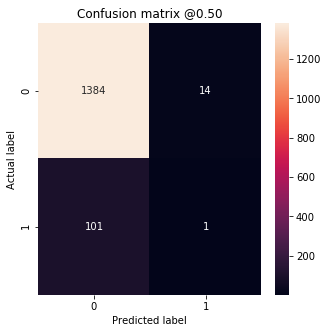

In [209]:
plot_cm(test_set_without_issue_num, test_predictions_baseline, threshold=0.5)

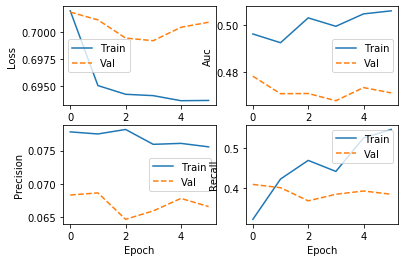

In [210]:
plot_metrics(history)

# LSTM

In [211]:
stage2 = Stage2PreprocData()
train_set, val_set, test_set = stage2.to_datasets()
train_set = train_set.shuffle(buffer_size=100000, seed=42, reshuffle_each_iteration=True)

def only_nixos_labels(dataset: tf.data.Dataset) -> tf.data.Dataset:                                                                                                                     
    return dataset.map(lambda issue_body, labels, issue_num: (issue_body, labels[-1]))   

In [212]:
train_set_without_issue_num = only_nixos_labels(train_set).batch(300).prefetch(1)
val_set_without_issue_num = only_nixos_labels(val_set).batch(1)
test_set_without_issue_num = only_nixos_labels(test_set).batch(1)

In [227]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape([1000, 1], input_shape=[1000]),
    #tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.LSTM(1, activation="sigmoid"),
])

model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.SGD(), 
    metrics=[
        tf.keras.metrics.Accuracy(name="acc"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 1000, 1)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1000, 10)          480       
_________________________________________________________________
lstm_5 (LSTM)                (None, 1)                 48        
Total params: 528
Trainable params: 528
Non-trainable params: 0
_________________________________________________________________


In [228]:
run_logdir = get_run_logdir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir, profile_batch=0)
history = model.fit(
    train_set_without_issue_num,
    epochs=100,
    validation_data=val_set_without_issue_num,
    callbacks=[tensorboard_cb, early_stopping],
    class_weight = class_weight,
)

Train for 42 steps, validate for 1600 steps
Epoch 1/100
42/42 [==============================] - 144s 3s/step - loss: 0.7155 - acc: 0.0000e+00 - tn: 11617.0000 - fp: 0.0000e+00 - fn: 945.0000 - tp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4965 - val_loss: 0.7166 - val_acc: 0.0000e+00 - val_tn: 1478.0000 - val_fp: 0.0000e+00 - val_fn: 122.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4756
Epoch 2/100
42/42 [==============================] - 142s 3s/step - loss: 0.7055 - acc: 0.0000e+00 - tn: 11617.0000 - fp: 0.0000e+00 - fn: 945.0000 - tp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5083 - val_loss: 0.7106 - val_acc: 0.0000e+00 - val_tn: 1478.0000 - val_fp: 0.0000e+00 - val_fn: 122.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4740
Epoch 3/100
42/42 [==============================] - 129s 3s/step - loss: 0.7010 - acc: 0.0000e+00 - tn: 11606.0000 - fp: 

In [229]:
train_predictions_baseline = model.predict(train_set_without_issue_num)
test_predictions_baseline = model.predict(test_set_without_issue_num)

In [230]:
pd.DataFrame(test_predictions_baseline).describe()

,0
count,1500.000000
mean,0.492289
std,0.010581
min,0.474416
25%,0.484533
50%,0.484533
75%,0.502348
max,0.561281


Issues that are correctly not labeled "nixos" (True Negatives):  831
Issues that are INCORRECTLY labeled "nixos" (False Positives):  567
Issues that should be labeled "nixos", but are INCORRECTLY not labeled (False Negatives):  59
Issues that are correctly labeled "nixos" (True Positives):  43


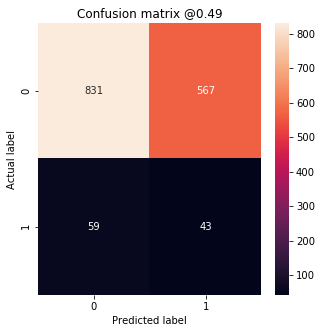

In [290]:
plot_cm(test_set_without_issue_num, test_predictions_baseline, threshold=0.4922)

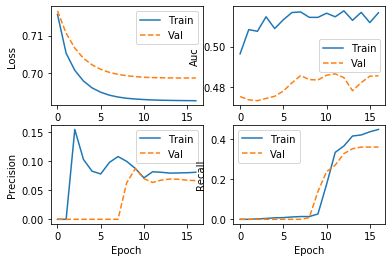

In [232]:
plot_metrics(history)

In [286]:
def find_false_pos(actual, predictions, threshold=0.5):
    all_false_pos = []
    for y_actual, y_pred in zip(actual, predictions):
        actual_val = y_actual[1][14]
        pred_val = 1 if y_pred[0] > threshold else 0
        if actual_val == 0 and pred_val == 1:
            all_false_pos.append((int(actual_val), y_pred[0], f"https://github.com/NixOS/nixpkgs/issues/{int(y_actual[2])}"))
        #print(y_actual[1][14], y_pred[0])
    return all_false_pos

In [289]:
find_false_pos(test_set, test_predictions_baseline, threshold=0.55)

[(0, 0.55791634, 'https://github.com/NixOS/nixpkgs/issues/66917'),
 (0, 0.5597661, 'https://github.com/NixOS/nixpkgs/issues/73228'),
 (0, 0.5574074, 'https://github.com/NixOS/nixpkgs/issues/83864'),
 (0, 0.56128144, 'https://github.com/NixOS/nixpkgs/issues/25092'),
 (0, 0.5532148, 'https://github.com/NixOS/nixpkgs/issues/76986'),
 (0, 0.56109065, 'https://github.com/NixOS/nixpkgs/issues/35322'),
 (0, 0.55229884, 'https://github.com/NixOS/nixpkgs/issues/22315')]

# GRU + Conv1D

In [4]:
stage2 = Stage2PreprocData()
train_set, val_set, test_set = stage2.to_datasets()
train_set = train_set.shuffle(buffer_size=100000, seed=42, reshuffle_each_iteration=True)

def only_label(dataset: tf.data.Dataset) -> tf.data.Dataset:                                                                                                                     
    return dataset.map(lambda issue_body, labels, issue_num: (issue_body, labels))   

In [5]:
#label_idx = -2
#train_set_without_issue_num = only_label_idx(train_set, label_idx).batch(300).prefetch(1)
#val_set_without_issue_num = only_label_idx(val_set, label_idx).batch(1)
#test_set_without_issue_num = only_label_idx(test_set, label_idx).batch(1)

In [6]:
#label_idx = -2
train_set_without_issue_num = only_label(train_set).batch(300).prefetch(1)
val_set_without_issue_num = only_label(val_set).batch(1)
test_set_without_issue_num = only_label(test_set).batch(1)

In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [43]:
#np.bincount(list(train_set_without_issue_num.unbatch().map(lambda x, y: y).as_numpy_iterator()))
list(train_set_without_issue_num.unbatch().map(lambda x, y: y).as_numpy_iterator())

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0,

In [36]:
neg_in_train, pos_in_train = np.bincount(list(train_set_without_issue_num.unbatch().map(lambda x, y: y).as_numpy_iterator()))
total_in_train = neg_in_train + pos_in_train
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total_in_train, pos_in_train, 100 * pos_in_train / total_in_train))

TypeError: in converted code:


    TypeError: <lambda>() takes 2 positional arguments but 3 were given


In [17]:
weight_for_0 = (1 / neg_in_train)*(total_in_train)/2.0 
weight_for_1 = (1 / pos_in_train)*(total_in_train)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.53
Weight for class 1: 9.59


In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape([1000, 1], input_shape=[1000]),
    #tf.keras.layers.Conv1D(filters=20, kernel_size=20, strides=2, padding="valid"),
    #tf.keras.layers.LSTM(20, return_sequences=True),
    #tf.keras.layers.GRU(10, return_sequences=True),
    tf.keras.layers.GRU(15, activation="sigmoid"),
])

model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=[
        tf.keras.metrics.Accuracy(name="acc"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1000, 1)           0         
_________________________________________________________________
gru (GRU)                    (None, 15)                810       
Total params: 810
Trainable params: 810
Non-trainable params: 0
_________________________________________________________________


In [9]:
run_logdir = get_run_logdir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir, profile_batch=0)
history = model.fit(
    train_set_without_issue_num,
    epochs=5,
    validation_data=val_set_without_issue_num,
    callbacks=[tensorboard_cb, early_stopping],
    #class_weight = class_weight,
)

Train for 42 steps, validate for 1600 steps
Epoch 1/5
42/42 [==============================] - 98s 2s/step - loss: 1.5897 - acc: 1.5921e-04 - tn: 121791.0000 - fp: 63008.0000 - fn: 2631.0000 - tp: 1000.0000 - precision: 0.0156 - recall: 0.2754 - auc: 0.4403 - val_loss: 1.4128 - val_acc: 1.6667e-04 - val_tn: 18438.0000 - val_fp: 5129.0000 - val_fn: 332.0000 - val_tp: 101.0000 - val_precision: 0.0193 - val_recall: 0.2333 - val_auc: 0.4507
Epoch 2/5
42/42 [==============================] - 90s 2s/step - loss: 1.3224 - acc: 1.4329e-04 - tn: 153021.0000 - fp: 31778.0000 - fn: 3039.0000 - tp: 592.0000 - precision: 0.0183 - recall: 0.1630 - auc: 0.4398 - val_loss: 1.2258 - val_acc: 1.2500e-04 - val_tn: 20144.0000 - val_fp: 3423.0000 - val_fn: 386.0000 - val_tp: 47.0000 - val_precision: 0.0135 - val_recall: 0.1085 - val_auc: 0.4419
Epoch 3/5
42/42 [==============================] - 96s 2s/step - loss: 1.1065 - acc: 4.2456e-05 - tn: 159172.0000 - fp: 25627.0000 - fn: 3296.0000 - tp: 335.0000 - 

In [10]:
#train_predictions_baseline = model.predict(train_set_without_issue_num)
test_predictions_baseline = model.predict(test_set_without_issue_num)

In [18]:
print(test_predictions_baseline[1])
list(test_set)[1][1]

[1.3439418e-03 2.4524459e-03 8.3285436e-02 6.4585137e-04 4.0707183e-01
 2.3281938e-01 7.6300197e-04 5.8906609e-01 6.2193428e-03 2.2855824e-02
 2.1393701e-02 3.3056751e-02 5.4768002e-08 2.0587686e-01 9.6505113e-02]


<tf.Tensor: shape=(15,), dtype=int64, numpy=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>

In [11]:
pd.DataFrame(test_predictions_baseline).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1.500000e+03,1500.000000,1500.000000
mean,0.178186,0.181821,0.207072,0.203906,0.376545,0.237928,0.187310,0.402414,0.178356,0.171516,0.220421,0.248936,1.472647e-01,0.302979,0.211885
std,0.143139,0.152494,0.070575,0.172380,0.076008,0.012822,0.151957,0.135864,0.133445,0.127081,0.150106,0.181152,1.254264e-01,0.061017,0.094905
min,0.000057,0.000001,0.069317,0.000009,0.284399,0.197564,0.000067,0.287815,0.002729,0.000377,0.003605,0.001146,2.746932e-08,0.076685,0.046891
25%,0.008183,0.003960,0.111158,0.003417,0.312466,0.233305,0.009960,0.287852,0.023914,0.022852,0.046986,0.040218,1.299939e-06,0.279557,0.094888
50%,0.302718,0.314965,0.256098,0.355721,0.312466,0.233305,0.320505,0.287852,0.295083,0.279616,0.349912,0.406646,2.568058e-01,0.279557,0.289559
75%,0.302718,0.314965,0.256098,0.355721,0.466209,0.236625,0.320505,0.537903,0.295083,0.279616,0.349912,0.406646,2.568058e-01,0.327511,0.289559
max,0.308015,0.314965,0.322988,0.355721,0.530266,0.311082,0.325494,0.739704,0.295083,0.297960,0.353754,0.406646,2.593372e-01,0.545468,0.332252


In [ ]:
lll = np.array(list(test_set_without_issue_num.map(lambda x, p: p).as_numpy_iterator())).reshape(-1)
confusion_matrix(lll, test_predictions_baseline >= 0.5)

In [22]:
def plot_cm(dataset, predictions, threshold=0.5):
    labels = np.array(list(dataset.map(lambda x, p: p).as_numpy_iterator())).reshape(-1)
    cm = confusion_matrix(labels, predictions >= threshold)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Issues that are correctly not labeled "nixos" (True Negatives): ', cm[0][0])
    print('Issues that are INCORRECTLY labeled "nixos" (False Positives): ', cm[0][1])
    print('Issues that should be labeled "nixos", but are INCORRECTLY not labeled (False Negatives): ', cm[1][0])
    print('Issues that are correctly labeled "nixos" (True Positives): ', cm[1][1])
    #print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Issues that are correctly not labeled "nixos" (True Negatives):  536
Issues that are INCORRECTLY labeled "nixos" (False Positives):  862
Issues that should be labeled "nixos", but are INCORRECTLY not labeled (False Negatives):  43
Issues that are correctly labeled "nixos" (True Positives):  59


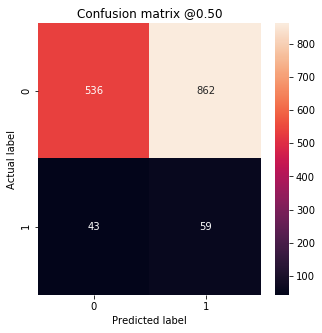

In [24]:
plot_cm(test_set_without_issue_num, test_predictions_baseline, threshold=0.50)

In [306]:
find_false_pos(test_set, test_predictions_baseline, threshold=0.55)

[(0, 0.55293673, 'https://github.com/NixOS/nixpkgs/issues/10809'),
 (0, 0.5546376, 'https://github.com/NixOS/nixpkgs/issues/38137'),
 (0, 0.5511592, 'https://github.com/NixOS/nixpkgs/issues/27605'),
 (0, 0.55279756, 'https://github.com/NixOS/nixpkgs/issues/5675'),
 (0, 0.5555428, 'https://github.com/NixOS/nixpkgs/issues/19988'),
 (0, 0.5512223, 'https://github.com/NixOS/nixpkgs/issues/44282'),
 (0, 0.5529154, 'https://github.com/NixOS/nixpkgs/issues/20383'),
 (0, 0.65011024, 'https://github.com/NixOS/nixpkgs/issues/45915'),
 (0, 0.55101585, 'https://github.com/NixOS/nixpkgs/issues/25640'),
 (0, 0.55299276, 'https://github.com/NixOS/nixpkgs/issues/60902'),
 (0, 0.5529521, 'https://github.com/NixOS/nixpkgs/issues/21984'),
 (0, 0.5848196, 'https://github.com/NixOS/nixpkgs/issues/42165'),
 (0, 0.55270165, 'https://github.com/NixOS/nixpkgs/issues/27416'),
 (0, 0.5519447, 'https://github.com/NixOS/nixpkgs/issues/29624'),
 (0, 0.55488443, 'https://github.com/NixOS/nixpkgs/issues/73318'),
 (0,

# GRU (big)

In [ ]:
stage2 = Stage2PreprocData()
train_set, val_set, test_set = stage2.to_datasets()
train_set = train_set.shuffle(buffer_size=100000, seed=42, reshuffle_each_iteration=True)

def only_nixos_labels(dataset: tf.data.Dataset) -> tf.data.Dataset:                                                                                                                     
    return dataset.map(lambda issue_body, labels, issue_num: (issue_body, labels[-1]))   

In [5]:
train_set_without_issue_num = only_nixos_labels(train_set).batch(70).prefetch(1)
val_set_without_issue_num = only_nixos_labels(val_set).batch(1)
test_set_without_issue_num = only_nixos_labels(test_set).batch(1)

In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [7]:
neg_in_train, pos_in_train = np.bincount(list(train_set_without_issue_num.unbatch().map(lambda x, y: y).as_numpy_iterator()))
total_in_train = neg_in_train + pos_in_train
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total_in_train, pos_in_train, 100 * pos_in_train / total_in_train))

Examples:
    Total: 12562
    Positive: 945 (7.52% of total)



In [8]:
weight_for_0 = (1 / neg_in_train)*(total_in_train)/2.0 
weight_for_1 = (1 / pos_in_train)*(total_in_train)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.54
Weight for class 1: 6.65


In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape([1000, 1], input_shape=[1000]),
    tf.keras.layers.GRU(250, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.GRU(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.GRU(1, activation="sigmoid"),
])

model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    metrics=[
        tf.keras.metrics.Accuracy(name="acc"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1000, 1)           0         
_________________________________________________________________
gru (GRU)                    (None, 1000, 250)         189750    
_________________________________________________________________
gru_1 (GRU)                  (None, 1000, 50)          45300     
_________________________________________________________________
gru_2 (GRU)                  (None, 1)                 159       
Total params: 235,209
Trainable params: 235,209
Non-trainable params: 0
_________________________________________________________________


In [10]:
run_logdir = get_run_logdir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir, profile_batch=0)
history = model.fit(
    train_set_without_issue_num,
    epochs=100,
    validation_data=val_set_without_issue_num,
    callbacks=[tensorboard_cb, early_stopping],
    class_weight = class_weight,
)

Train for 180 steps, validate for 1600 steps
Epoch 1/100
170/180 [===========================>..] - ETA: 1:12 - loss: 0.7051 - acc: 0.0000e+00 - tn: 6107.0000 - fp: 4827.0000 - fn: 479.0000 - tp: 417.0000 - precision: 0.0795 - recall: 0.4654 - auc: 0.5026WARNING:tensorflow:Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: loss,acc,tn,fp,fn,tp,precision,recall,auc


KeyboardInterrupt: 

In [ ]:
train_predictions_baseline = model.predict(train_set_without_issue_num)
test_predictions_baseline = model.predict(test_set_without_issue_num)

In [18]:
pd.DataFrame(test_predictions_baseline).describe()

,0
count,1500.000000
mean,0.501954
std,0.018947
min,0.362569
25%,0.499319
50%,0.501195
75%,0.501195
max,0.738379


In [19]:
def plot_cm(dataset, predictions, threshold=0.5):
    labels = np.array(list(dataset.map(lambda x, p: p).as_numpy_iterator())).reshape(-1)
    cm = confusion_matrix(labels, predictions >= threshold)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Issues that are correctly not labeled "nixos" (True Negatives): ', cm[0][0])
    print('Issues that are INCORRECTLY labeled "nixos" (False Positives): ', cm[0][1])
    print('Issues that should be labeled "nixos", but are INCORRECTLY not labeled (False Negatives): ', cm[1][0])
    print('Issues that are correctly labeled "nixos" (True Positives): ', cm[1][1])
    #print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Issues that are correctly not labeled "nixos" (True Negatives):  1372
Issues that are INCORRECTLY labeled "nixos" (False Positives):  26
Issues that should be labeled "nixos", but are INCORRECTLY not labeled (False Negatives):  101
Issues that are correctly labeled "nixos" (True Positives):  1


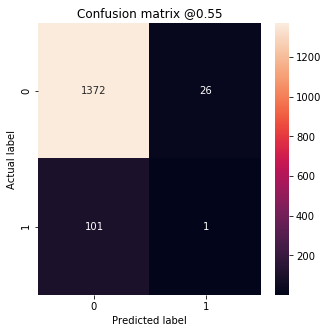

In [20]:
plot_cm(test_set_without_issue_num, test_predictions_baseline, threshold=0.55)

In [286]:
def find_false_pos(actual, predictions, threshold=0.5):
    all_false_pos = []
    for y_actual, y_pred in zip(actual, predictions):
        actual_val = y_actual[1][14]
        pred_val = 1 if y_pred[0] > threshold else 0
        if actual_val == 0 and pred_val == 1:
            all_false_pos.append((int(actual_val), y_pred[0], f"https://github.com/NixOS/nixpkgs/issues/{int(y_actual[2])}"))
        #print(y_actual[1][14], y_pred[0])
    return all_false_pos

In [306]:
find_false_pos(test_set, test_predictions_baseline, threshold=0.55)

[(0, 0.55293673, 'https://github.com/NixOS/nixpkgs/issues/10809'),
 (0, 0.5546376, 'https://github.com/NixOS/nixpkgs/issues/38137'),
 (0, 0.5511592, 'https://github.com/NixOS/nixpkgs/issues/27605'),
 (0, 0.55279756, 'https://github.com/NixOS/nixpkgs/issues/5675'),
 (0, 0.5555428, 'https://github.com/NixOS/nixpkgs/issues/19988'),
 (0, 0.5512223, 'https://github.com/NixOS/nixpkgs/issues/44282'),
 (0, 0.5529154, 'https://github.com/NixOS/nixpkgs/issues/20383'),
 (0, 0.65011024, 'https://github.com/NixOS/nixpkgs/issues/45915'),
 (0, 0.55101585, 'https://github.com/NixOS/nixpkgs/issues/25640'),
 (0, 0.55299276, 'https://github.com/NixOS/nixpkgs/issues/60902'),
 (0, 0.5529521, 'https://github.com/NixOS/nixpkgs/issues/21984'),
 (0, 0.5848196, 'https://github.com/NixOS/nixpkgs/issues/42165'),
 (0, 0.55270165, 'https://github.com/NixOS/nixpkgs/issues/27416'),
 (0, 0.5519447, 'https://github.com/NixOS/nixpkgs/issues/29624'),
 (0, 0.55488443, 'https://github.com/NixOS/nixpkgs/issues/73318'),
 (0,